In [24]:
# !pip install xgboost
import torch
import torch.nn as nn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
features = 8
batch_size = 900
device = "cpu"
epochs = 20
learning_rate = 0.001

# Data Exploration, Analysis & Visualization

In [3]:
data = pd.read_csv('Diabetes.csv')
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [4]:
print(data.info(),"\n\n")
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None 


       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std 

<AxesSubplot:xlabel='Outcome', ylabel='count'>

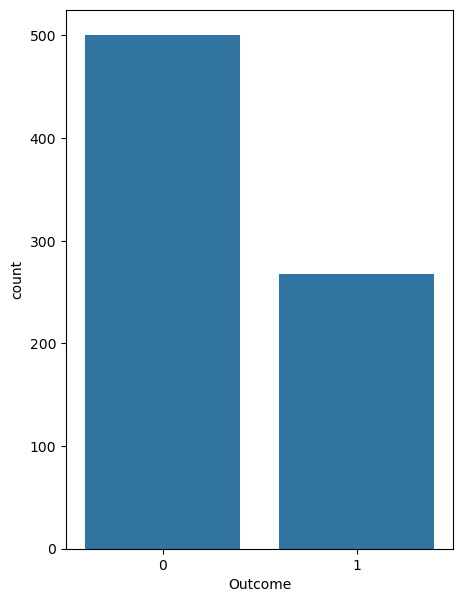

In [5]:
plt.figure(figsize=(5,7))
sns.countplot(x="Outcome", data=data)

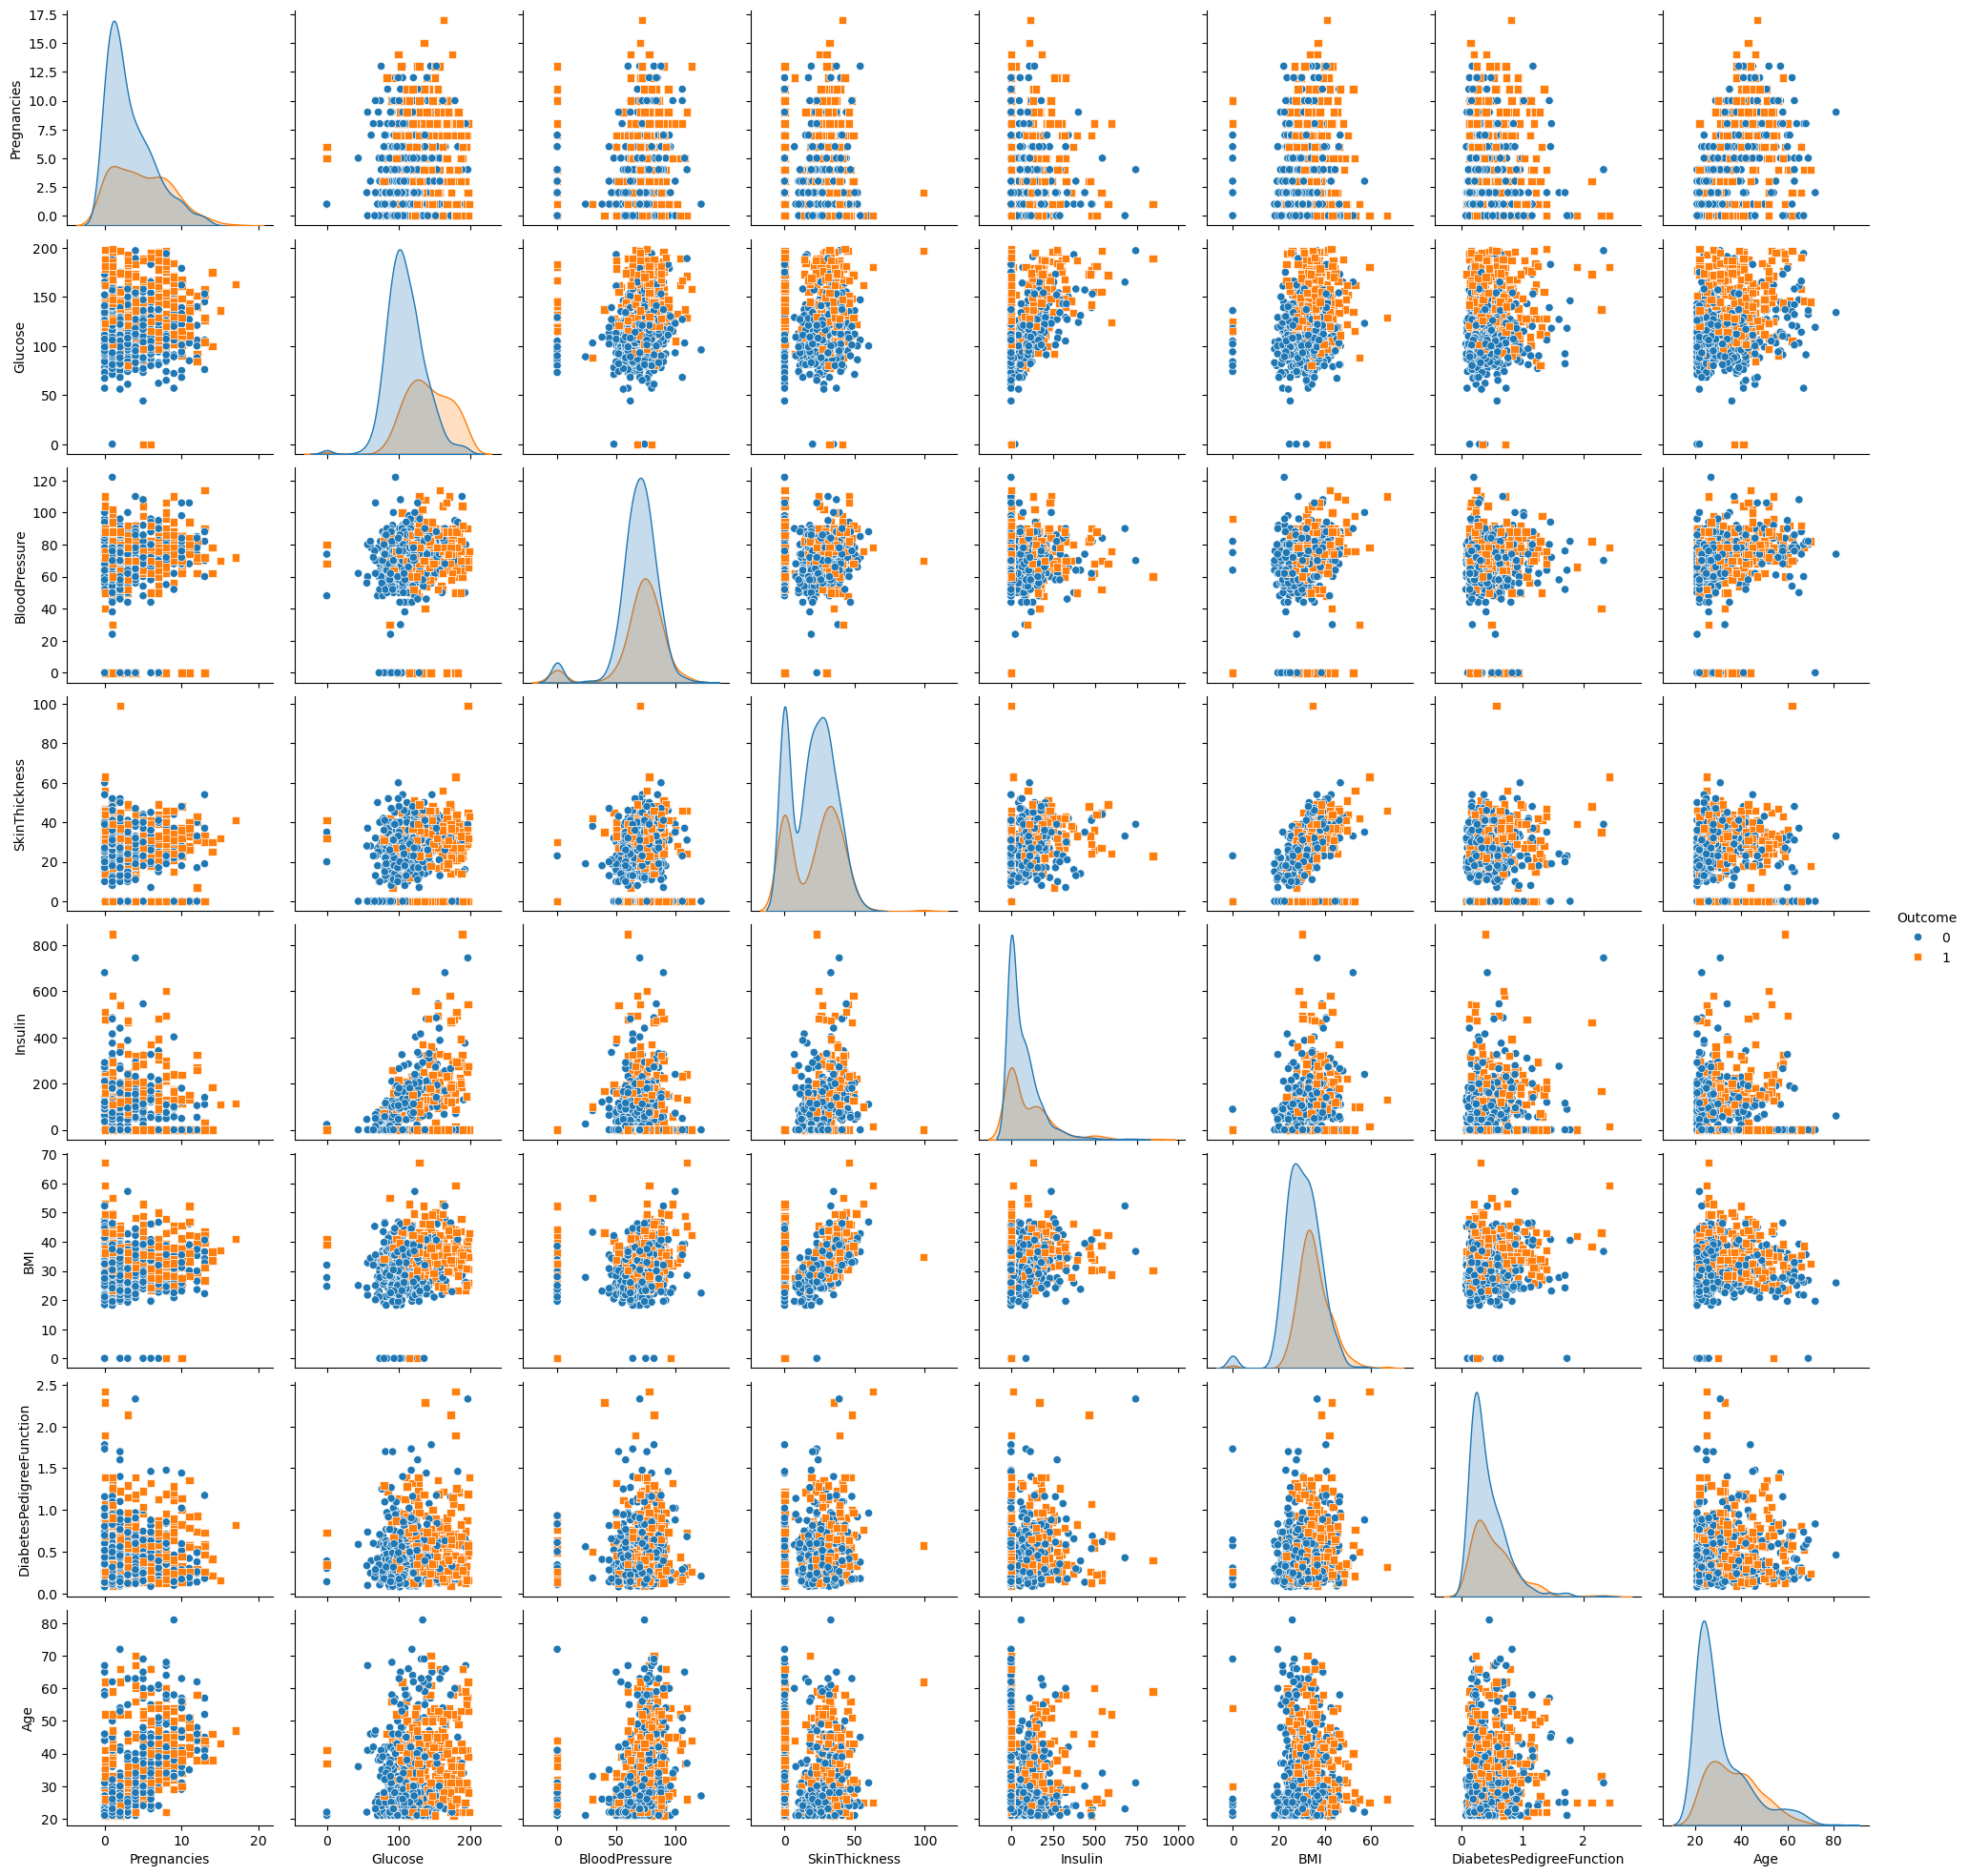

In [92]:
sns.pairplot(data, hue="Outcome",  markers=["o", "s"])
plt.show()

# Data Split & Scaling

In [7]:
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [8]:
sc = StandardScaler()
scaleddata= sc.fit_transform(data.iloc[:,0:8])

In [9]:
scaleddata

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

# Neural Network

## Data Processing

In [10]:
x_train, x_test, y_train, y_test = train_test_split(scaleddata, data.iloc[:,features] , test_size=0.25)
X_train = torch.tensor(x_train, dtype = torch.float32)
X_test = torch.tensor(x_test, dtype = torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype = torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.to_numpy(), dtype = torch.float32).unsqueeze(1)

In [11]:
trainset = TensorDataset(X_train, y_train)
testset = TensorDataset(X_test, y_test)

In [12]:
TrainLoader = DataLoader(trainset, batch_size=batch_size, shuffle = True)
TestLoader = DataLoader(testset, batch_size = 200)

In [13]:
class Classifier(nn.Module):
    def __init__(self, inpLen):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(inpLen, 400, bias=True)
        self.layer2 = nn.Linear(400, 400, bias = True)
        self.output = nn.Linear(400,1)
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.output(x)
        x = torch.sigmoid(x)
        return x

In [14]:
model = Classifier(features)

In [15]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [16]:
criterion = nn.BCELoss()

## Training & Eval Function

In [17]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    tloss = 0
    for (inputs, targets) in tqdm(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        y_preds = model(inputs)
        loss = criterion(y_preds, targets)
        loss.backward()
        optimizer.step()

        tloss += loss
    return tloss

In [18]:
def validate(model, dataloader, criterion):
    model.eval()
    tloss = 0
    for (input, targets) in dataloader:
        input = input.to(device)
        y_preds = model(input)
        
        loss = criterion(y_preds, targets)
        tloss = tloss + loss
    return tloss/len(dataloader)

## Training

In [19]:
best_loss = np.inf
for i in range(epochs):
    trainLoss = train(model, TrainLoader, optimizer, criterion)
    validLoss = validate(model, TestLoader, criterion)
    print(f"Epoch {i}, TrainLoss: {trainLoss}, Validation Loss: {validLoss}")
    if(best_loss > validLoss):
        best_loss = validLoss
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved this model")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.64it/s]


Epoch 0, TrainLoss: 0.6902697682380676, Validation Loss: 0.6278451085090637
Saved this model


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.28it/s]


Epoch 1, TrainLoss: 0.6284474730491638, Validation Loss: 0.5858794450759888
Saved this model


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.32it/s]


Epoch 2, TrainLoss: 0.5823329091072083, Validation Loss: 0.5550693869590759
Saved this model


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.90it/s]


Epoch 3, TrainLoss: 0.5459846258163452, Validation Loss: 0.5327962040901184
Saved this model


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.50it/s]


Epoch 4, TrainLoss: 0.5173421502113342, Validation Loss: 0.5186715126037598
Saved this model


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.32it/s]


Epoch 5, TrainLoss: 0.49557384848594666, Validation Loss: 0.5115099549293518
Saved this model


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 84.96it/s]


Epoch 6, TrainLoss: 0.47964349389076233, Validation Loss: 0.5093755722045898
Saved this model


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.33it/s]


Epoch 7, TrainLoss: 0.46803441643714905, Validation Loss: 0.5103667378425598


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.27it/s]


Epoch 8, TrainLoss: 0.45932871103286743, Validation Loss: 0.5132564902305603


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.50it/s]


Epoch 9, TrainLoss: 0.4527861177921295, Validation Loss: 0.5170938968658447


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.60it/s]


Epoch 10, TrainLoss: 0.4479709267616272, Validation Loss: 0.5208479166030884


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 84.11it/s]


Epoch 11, TrainLoss: 0.44442620873451233, Validation Loss: 0.5239853262901306


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.10it/s]


Epoch 12, TrainLoss: 0.4417692720890045, Validation Loss: 0.5262904763221741


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.81it/s]


Epoch 13, TrainLoss: 0.43969282507896423, Validation Loss: 0.5277934670448303


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.06it/s]


Epoch 14, TrainLoss: 0.4377087652683258, Validation Loss: 0.5285260081291199


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 94.23it/s]


Epoch 15, TrainLoss: 0.43526050448417664, Validation Loss: 0.5284714698791504


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.86it/s]


Epoch 16, TrainLoss: 0.43214625120162964, Validation Loss: 0.5276668667793274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.00it/s]


Epoch 17, TrainLoss: 0.4284857213497162, Validation Loss: 0.5261719822883606


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.17it/s]


Epoch 18, TrainLoss: 0.42450618743896484, Validation Loss: 0.524118959903717


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.85it/s]

Epoch 19, TrainLoss: 0.42051172256469727, Validation Loss: 0.5219554305076599


## Inference & Analysis

In [20]:
model.load_state_dict(torch.load("best_model.pt"))

C:\Users\Ashish\AppData\Local\Temp\ipykernel_6960\349716640.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


<All keys matched successfully>

In [21]:
model.eval()
val = []
target = []
for input, target in TestLoader:
    input = input.to(device)
    target = target.squeeze(0).numpy()
    y_pred = model(input)
    val = np.round(y_pred.detach().cpu().squeeze(0).numpy())

<AxesSubplot:>

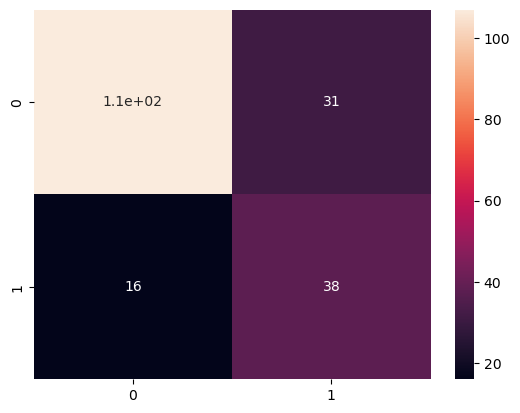

In [22]:
cm = confusion_matrix(val, target)
sns.heatmap(cm, annot = True)

In [69]:
print(classification_report(val, target))

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       123
         1.0       0.68      0.68      0.68        69

    accuracy                           0.77       192
   macro avg       0.75      0.75      0.75       192
weighted avg       0.77      0.77      0.77       192



# XGBoost

In [79]:
X_train, X_test, y_train, y_test = train_test_split(scaleddata, data.iloc[:,features].to_numpy() , test_size=0.25)
# X_train = train[: , :features]
# y_train = np.expand_dims(train[:, features], axis=1)
print(X_train.shape, test.shape)

(576, 8) (192, 9)


In [86]:
model = xgb.XGBClassifier(learning_rate = 0.1, n_estimators = 10, max_depth=8)

In [87]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [88]:
results = model.score(X_train, y_train)
print(results)

0.9045138888888888


In [89]:
results = model.score(test[:,:features], np.expand_dims(test[:,features], axis=-1))
print(results)

0.5885416666666666


In [90]:
y_pred = model.predict(test[:,:features])

<AxesSubplot:>

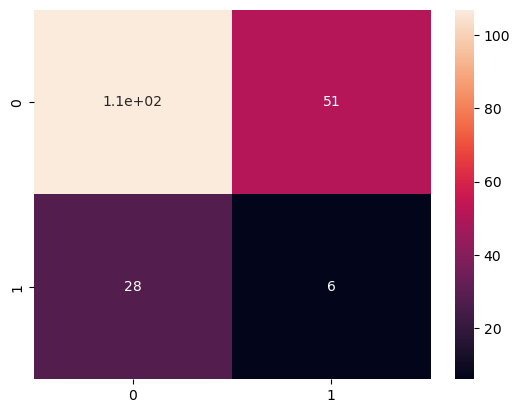

In [91]:
cm = confusion_matrix(y_pred, np.expand_dims(test[:,features], axis=-1))
sns.heatmap(cm, annot=True)

# Rough

In [94]:
corr = data["Insulin"].corr(data["Outcome"])
corr

0.13054795488404788

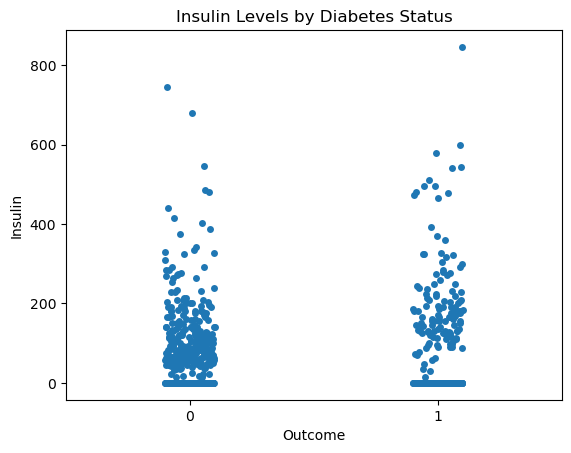

In [99]:
sns.stripplot(x='Outcome', y='Insulin', data=data, jitter=True)
plt.title('Insulin Levels by Diabetes Status')
plt.show()